# Satellite Image ConvLSTM Implementation

The data is from the U.S. Geological Survey's Sentinel 2 Satellite launched 23 June 2015, orbiting at 786 km, performing 14.3 revolutions around the Earth per day. 

The Sentinel-2 MultiSpectral Instrument (MSI) acquires 13 spectral bands ranging from Visible and Near-Infrared (VNIR) to Shortwave Infrared (SWIR) wavelengths along a 290-km orbital swath.

The MSI measures reflected radiance through the atmosphere within 13 spectral bands. The spatial resolution is dependent on the particular spectral band:

 - 4 bands at 10 meter: blue (490 nm), green (560 nm), red (665 nm), and near-infrared (842 nm).
 - 6 bands at 20 meter: 4 narrow bands for *vegetation characterization* (705 nm, 740 nm, 783 nm, and 865 nm) and 2 larger SWIR bands (1,610 nm and 2,190 nm) for applications such as *snow/ice/cloud detection* or *vegetation moisture stress assessment*.
 - 3 bands at 60 meter: mainly for *cloud screening and atmospheric corrections* (443 nm for aerosols, 945 nm for *water vapor*, and 1375 nm for *cirrus detection*).

We looked at the SWIR band and 60 meter band data spaced 2-3 days apart each from March 2015 to March 2020 in the Los Angeles County area.

## Data Manipulation

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

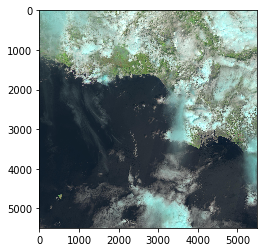

In [3]:
image = plt.imread("/Users/Pannu/Desktop/Satellite Image Dataset/20190429T183604.tif",cv2.IMREAD_UNCHANGED)
plt.imshow(image)

The black and white clouds correspond to **general particulate matter** in the atmosphere. The blue clouds correspond to **nitrogen dioxide**. 

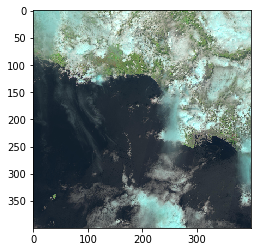

In [4]:
imageS = cv2.resize(image,(400,400))
plt.imshow(imageS)

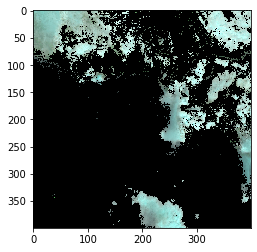

In [5]:
import cv2
import numpy as np
img_hsv = cv2.cvtColor(imageS, cv2.COLOR_BGR2HSV)
hsv_color2 = np.asarray([60, 255, 255], np.uint8) 
hsv_color1 = np.asarray([30, 30, 30], np.uint8)   

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

res = cv2.bitwise_and(imageS,imageS, mask = mask)

plt.imshow(res)   # this colormap will display in black / white
plt.show()

In [6]:
import cv2
from skimage import data, img_as_float
h, z, img_gray = cv2.split(res)


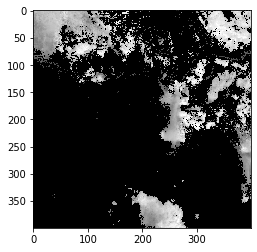

In [7]:
plt.imshow(img_gray, cmap="gray")

In [8]:
img_gray[img_gray > 0] = 1


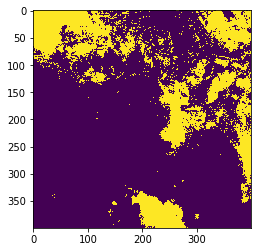

In [9]:
plt.imshow(img_gray)

In [10]:
import os
from sklearn import preprocessing
all_samples = np.empty(shape=(230,40,40,1))
count = 1;
for x in sorted(os.listdir("/Users/Pannu/Desktop/Satellite Image Dataset/")):
        photo = cv2.imread("/Users/Pannu/Desktop/Satellite Image Dataset/" + x)
        photo = cv2.resize(photo,(40,40))
        photo_hsv = cv2.cvtColor(photo, cv2.COLOR_BGR2HSV)
        p_hsv_color2 = np.asarray([60, 255, 255], np.uint8) 
        p_hsv_color1 = np.asarray([30, 30, 30], np.uint8)   
        photo_mask = cv2.inRange(photo_hsv, p_hsv_color1, p_hsv_color2)
        photo_res = cv2.bitwise_and(photo,photo, mask = photo_mask)
        p_h, p_z, p_img_gray = cv2.split(photo_res)
        p_img_gray[p_img_gray > 0] = 1
        p_img_gray = np.reshape(p_img_gray,(40,40,1))
        all_samples[count] = p_img_gray
        print(count, "images added")
        count = count + 1

1 images added
2 images added
3 images added
4 images added
5 images added
6 images added
7 images added
8 images added
9 images added
10 images added
11 images added
12 images added
13 images added
14 images added
15 images added
16 images added
17 images added
18 images added
19 images added
20 images added
21 images added
22 images added
23 images added
24 images added
25 images added
26 images added
27 images added
28 images added
29 images added
30 images added
31 images added
32 images added
33 images added
34 images added
35 images added
36 images added
37 images added
38 images added
39 images added
40 images added
41 images added
42 images added
43 images added
44 images added
45 images added
46 images added
47 images added
48 images added
49 images added
50 images added
51 images added
52 images added
53 images added
54 images added
55 images added
56 images added
57 images added
58 images added
59 images added
60 images added
61 images added
62 images added
63 images added
6

In [11]:
all_samples[225] = all_samples[0]
all_samples[226] = all_samples[1]
all_samples[227] = all_samples[2]
all_samples[228] = all_samples[3]
all_samples[229] = all_samples[4]

In [12]:
all_samples.shape # (230,40,40,1)

(230, 40, 40, 1)

In [13]:
#4D tensor to 5D tensor
count = 0
final = np.empty((225,5,40,40,1))
for i in range(225):
    bundle = np.array([all_samples[i],all_samples[i+1],all_samples[i+2],all_samples[i+3],all_samples[i+4]])
    final[i] = bundle
X_train = final[0:165]
X_test = final[166:221]
print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")

(165, 5, 40, 40, 1) X_train shape
(55, 5, 40, 40, 1) X_test shape


In [14]:
y_train = final[5:170]
y_test = final[171:226]
print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")

(165, 5, 40, 40, 1) X_train shape
(55, 5, 40, 40, 1) X_test shape


In [15]:
all_samples.shape

(230, 40, 40, 1)

-----
# Keras ConvLSTM2D Layer Implementation

https://github.com/bruce803/Air-quality-prediction

## ConvLSTM2D

```
keras.layers.ConvLSTM2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0)
```
### Convolutional LSTM.

It is similar to an LSTM layer, but the input transformations and recurrent transformations are both convolutional.

### Arguments

 - **filters**: Integer, the dimensionality of the output space (i.e. the number output of filters in the convolution).
 - **kernel_size**: An integer or tuple/list of n integers, specifying the dimensions of the convolution window.
 - **strides**: An integer or tuple/list of n integers, specifying the strides of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
 - **padding:** One of "valid" or "same" (case-insensitive).
 - **data_format:** A string, one of "channels_last" (default) or "channels_first". The ordering of the dimensions in the inputs. "channels_last" corresponds to inputs with shape (batch, time, ..., channels) while "channels_first" corresponds to inputs with shape (batch, time, channels, ...). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
 - **dilation_rate:** An integer or tuple/list of n integers, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.
 - **activation:** Activation function to use (see activations).
 - **recurrent_activation:** Activation function to use for the recurrent step (see activations).
 - **use_bias:** Boolean, whether the layer uses a bias vector.
 - **kernel_initializer:** Initializer for the kernel weights matrix, used for the linear transformation of the inputs. (see initializers).
 - **recurrent_initializer:** Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. (see initializers).
 - **bias_initializer:** Initializer for the bias vector (see initializers).
 - **unit_forget_bias:** Boolean. If True, add 1 to the bias of the forget gate at initialization. Use in combination with bias_initializer="zeros". This is recommended in Jozefowicz et al. (2015).
 - **kernel_regularizer:** Regularizer function applied to the kernel weights matrix (see regularizer).
 - **recurrent_regularizer:** Regularizer function applied to the recurrent_kernel weights matrix (see regularizer).
 - **bias_regularizer:** Regularizer function applied to the bias vector (see regularizer).
 - **activity_regularizer:** Regularizer function applied to the output of the layer (its "activation"). (see regularizer).
 - **kernel_constraint:** Constraint function applied to the kernel weights matrix (see constraints).
 - **recurrent_constraint:** Constraint function applied to the recurrent_kernel weights matrix (see constraints).
 - **bias_constraint:** Constraint function applied to the bias vector (see constraints).
 - **return_sequences:** Boolean. Whether to return the last output in the output sequence, or the full sequence.
 - **go_backwards:** Boolean (default False). If True, process the input sequence backwards.
 - **stateful:** Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
 - **dropout:** Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
 - **recurrent_dropout:** Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

#### Input shape

 - **if data_format='channels_first' 5D tensor with shape:** (samples, time, channels, rows, cols)

 - **if data_format='channels_last' 5D tensor with shape:** (samples, time, rows, cols, channels)

#### Output shape

 - **if return_sequences**
 - **if data_format='channels_first' 5D tensor with shape:** (samples, time, filters, output_row, output_col)
 - **if data_format='channels_last' 5D tensor with shape:** (samples, time, output_row, output_col, filters)
 - **else**

 - **if data_format='channels_first' 4D tensor with shape:** (samples, filters, output_row, output_col)
 - **if data_format='channels_last' 4D tensor with shape:** (samples, output_row, output_col, filters)
 - **where o_row and o_col depend on the shape of the filter and the padding**

#### Raises

 - **ValueError:** in case of invalid constructor arguments.

#### References

Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting The current implementation does not include the feedback loop on the cells output

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.
/anaconda3/envs/stocks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/stocks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/stocks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/stocks/lib/python3.7/site-packages/tenso

## seq2seq model

In [101]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=1, kernel_size=(2, 2),
                   input_shape=(5, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='mean_absolute_error', optimizer='nadam')
#seq.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae', 'acc'])


## training

In [102]:
seq.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.1)

Train on 148 samples, validate on 17 samples
Epoch 1/50
148/148 [==============================] - 7s 50ms/step - loss: 0.5253 - val_loss: 0.3853
Epoch 2/50
148/148 [==============================] - 3s 21ms/step - loss: 0.4195 - val_loss: 0.3063
Epoch 3/50
148/148 [==============================] - 3s 23ms/step - loss: 0.3506 - val_loss: 0.2913
Epoch 4/50
148/148 [==============================] - 4s 30ms/step - loss: 0.2964 - val_loss: 0.2748
Epoch 5/50
148/148 [==============================] - 3s 19ms/step - loss: 0.2644 - val_loss: 0.2510
Epoch 6/50
148/148 [==============================] - 3s 22ms/step - loss: 0.2460 - val_loss: 0.2273
Epoch 7/50
148/148 [==============================] - 5s 31ms/step - loss: 0.2325 - val_loss: 0.2071
Epoch 8/50
148/148 [==============================] - 3s 19ms/step - loss: 0.2210 - val_loss: 0.1880
Epoch 9/50
148/148 [==============================] - 3s 23ms/step - loss: 0.2093 - val_loss: 0.1696
Epoch 10/50
148/148 [=========================

## prediction

In [103]:
Y_hat = seq.predict(X_test, verbose=0)
Y_hat.shape
y_test.shape

(54, 5, 40, 40, 1)

## visualization

In [104]:
from sklearn import preprocessing
def visulization(y, y_hat, n_slots):
    '''
    visulize the prpcess of prediction by randomly select n_slots predictions.
    y: the labels of test set: shape like (200, 9, 9, 1)
    y_hat: the predicted labels: shape like (200, 9, 9, 1)
    n_slots: number of frames to be visulized
    '''
    import random
    import matplotlib.pyplot as plt
    import numpy as np
    length = y_hat.shape[0]
    random_ind = [x for x in range(0,n_slots)]
    stations = ['0', '1', '2', '3', '4', '5', '6']
#     fea = ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pressure', 'temperature', 'humidity']
    fea = ['0', '1', '2', '3', '4']
    setCount = 1;
    for ind in random_ind:
        setCount = setCount+1;
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
        #plt.yticks(np.arange(7), stations, fontsize=12)
        #ax1.set_yticklabels(stations,fontsize=13)
       # ax1.set_xticklabels(fea)
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
        #plt.setp(ax1, xticks = [0, 1, 2,3,4,5,6])
    
        #plt.setp(ax1.get_xticklabels(), rotation=30,ha="right", rotation_mode="anchor")
        #plt.setp(ax2.get_xticklabels(), rotation=30)
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,0,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,0,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'NEW SET, Ground truth Frame 1', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,1,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,1,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 2', fontsize=13)
    
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,2,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,2,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 3', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,3,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)

#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,3,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 4', fontsize=13)
    
        fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,4,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,4,:,:,0]
        ax2.imshow(y_truth)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 5', fontsize=13)
    

/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

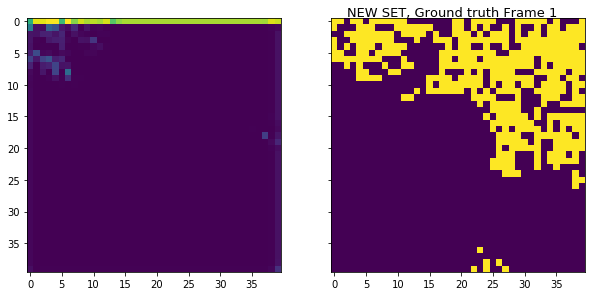

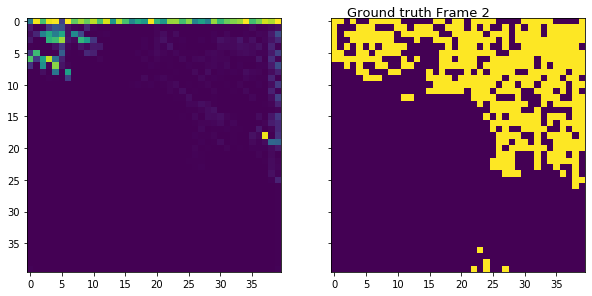

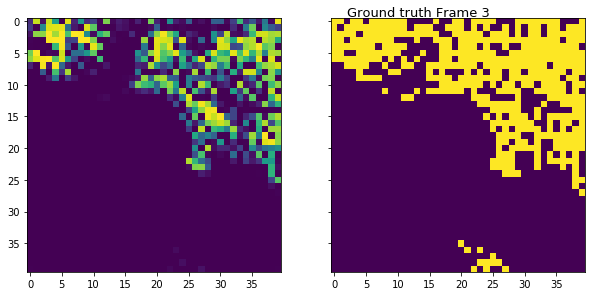

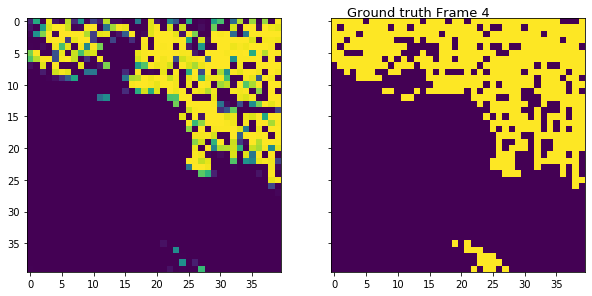

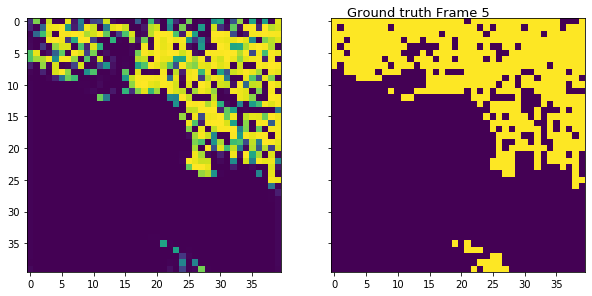

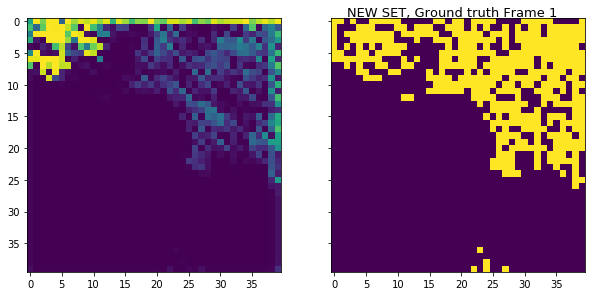

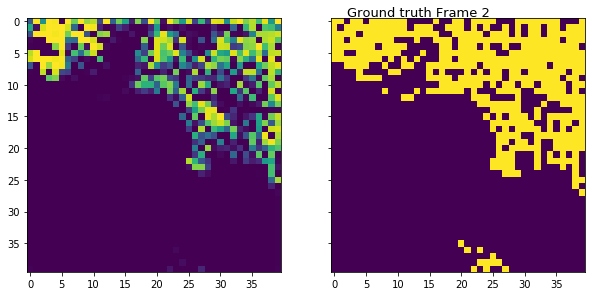

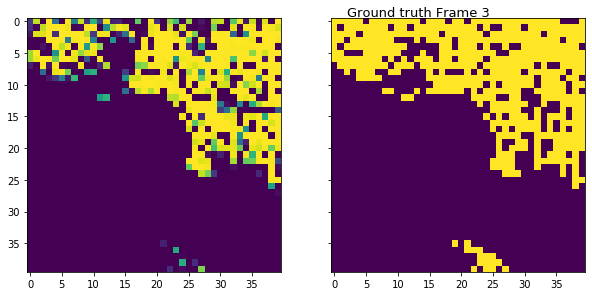

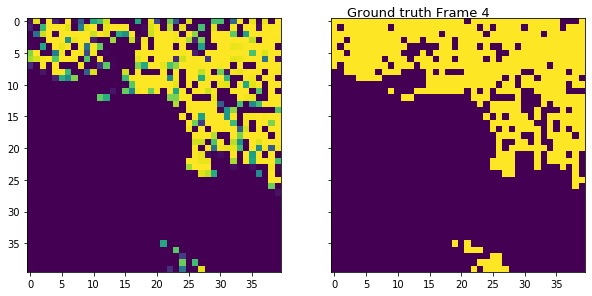

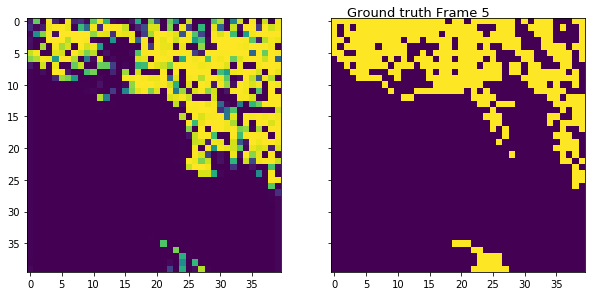

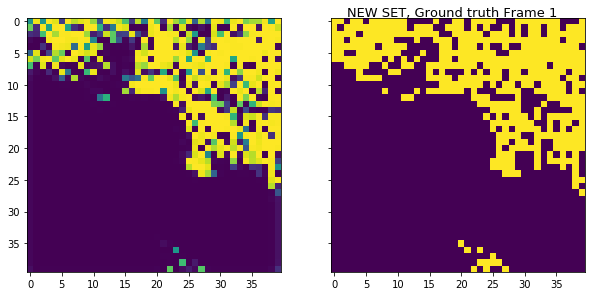

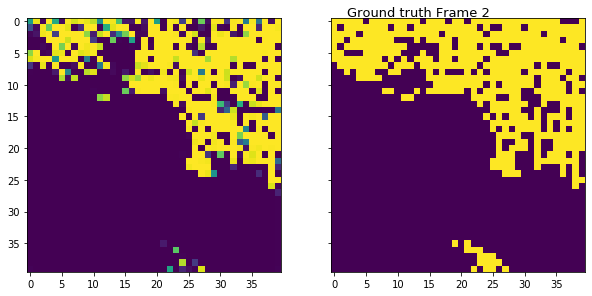

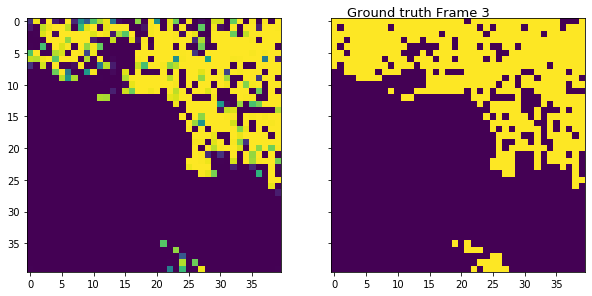

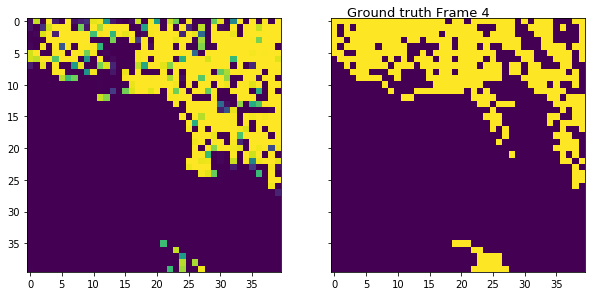

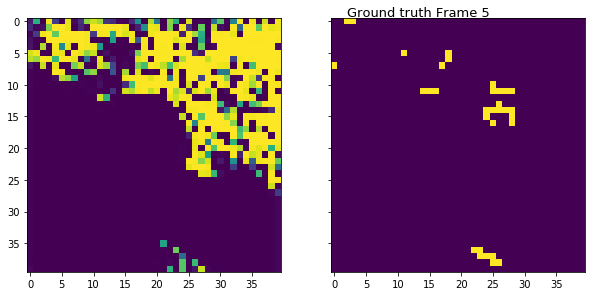

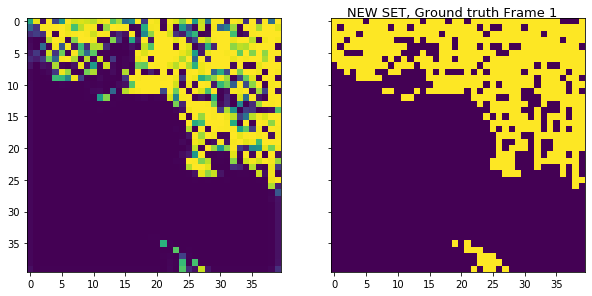

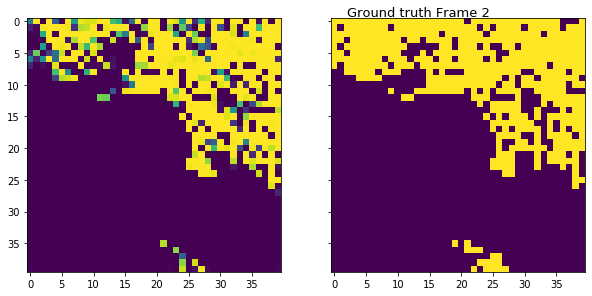

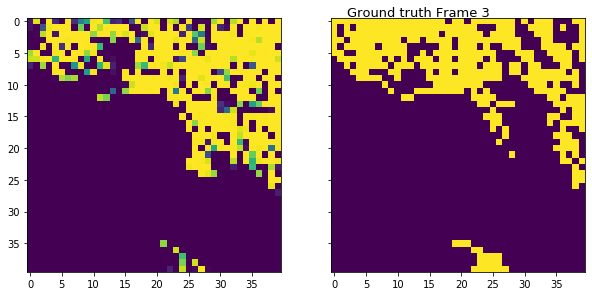

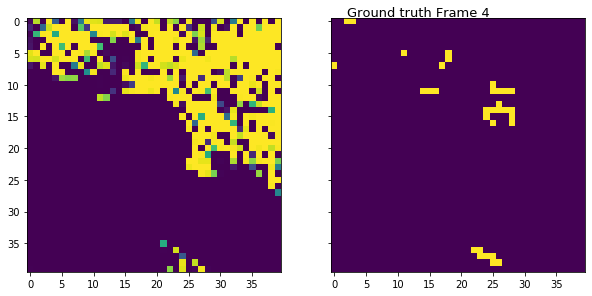

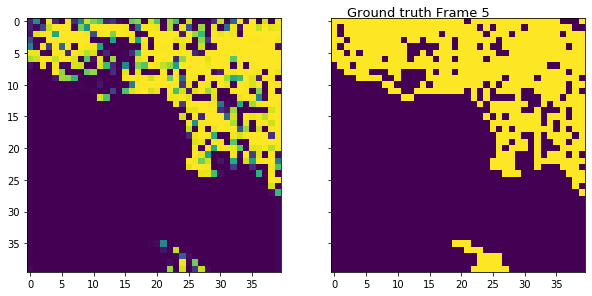

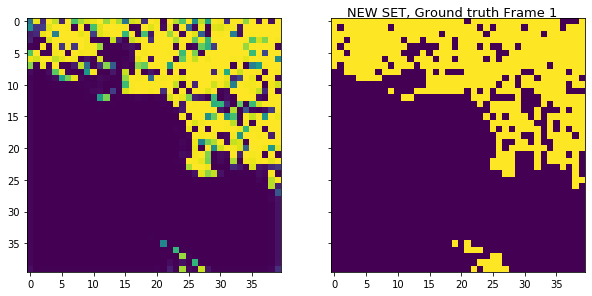

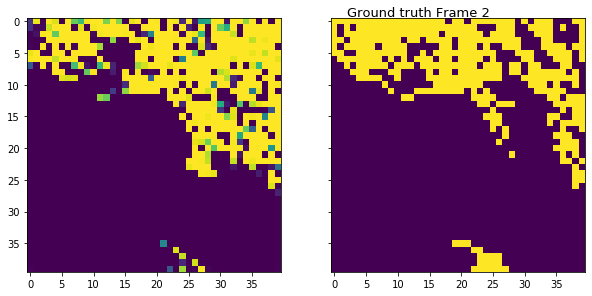

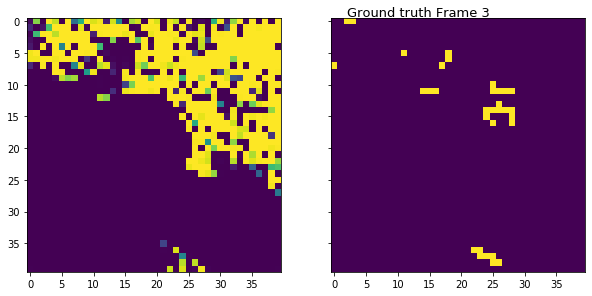

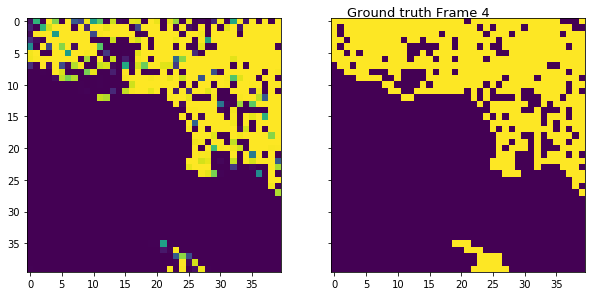

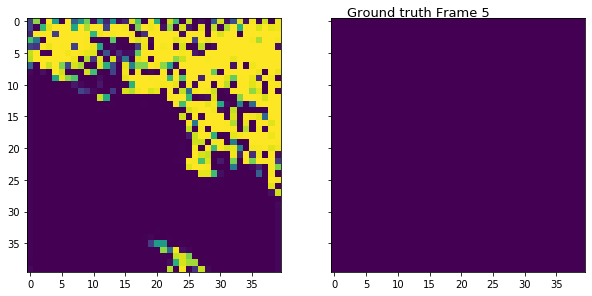

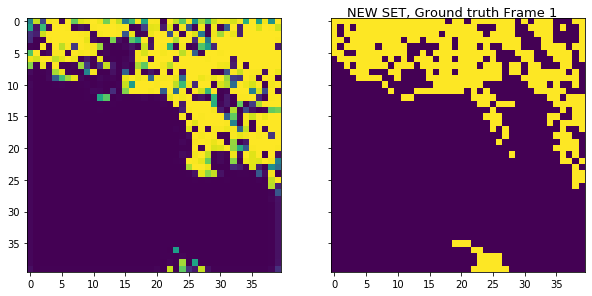

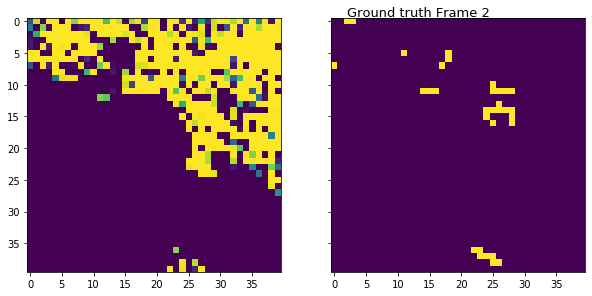

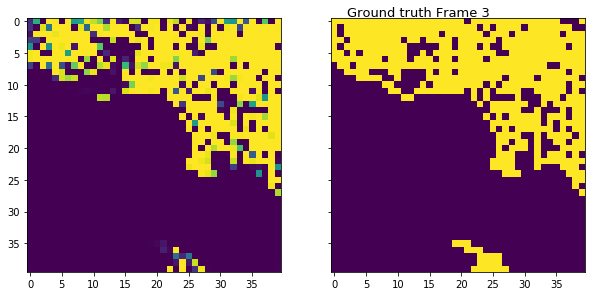

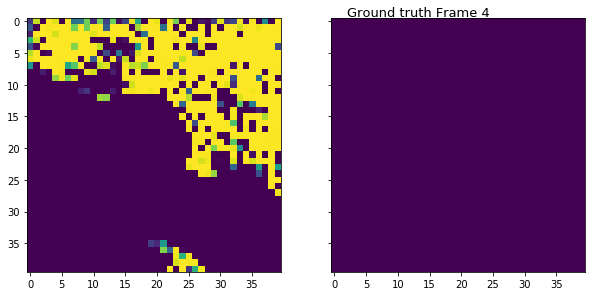

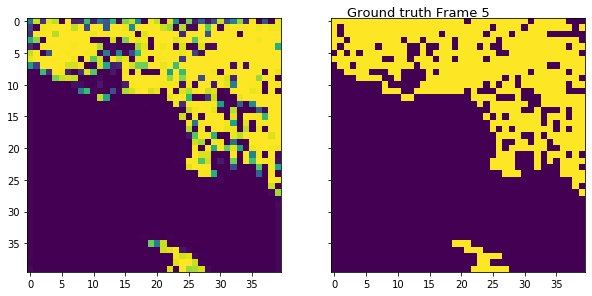

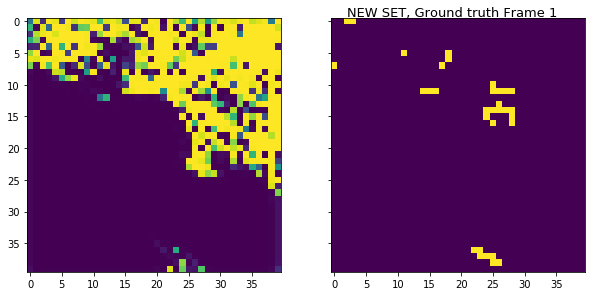

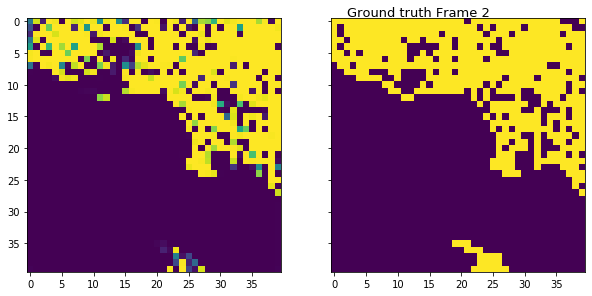

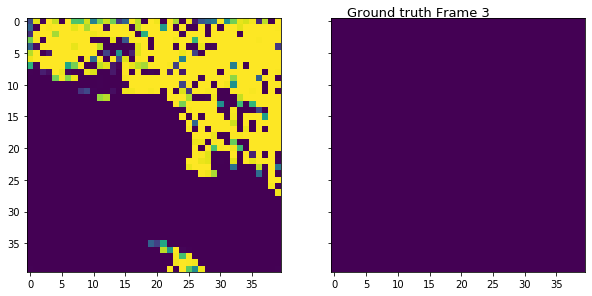

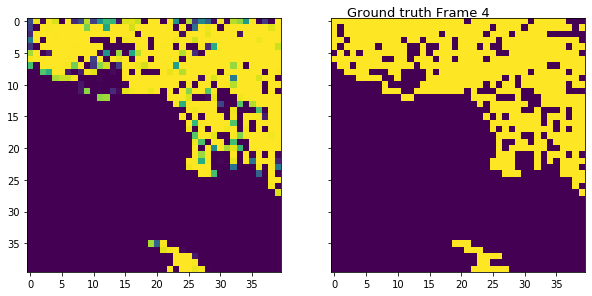

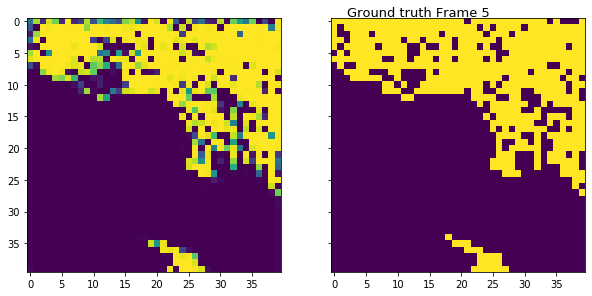

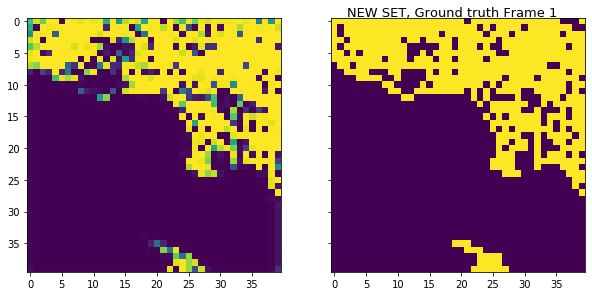

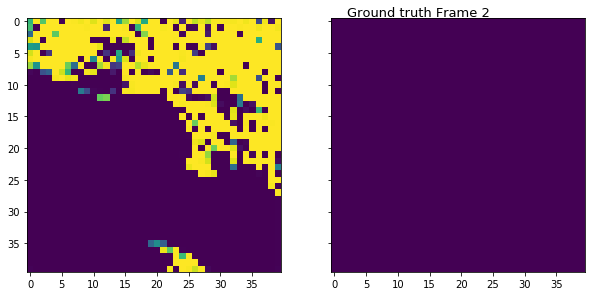

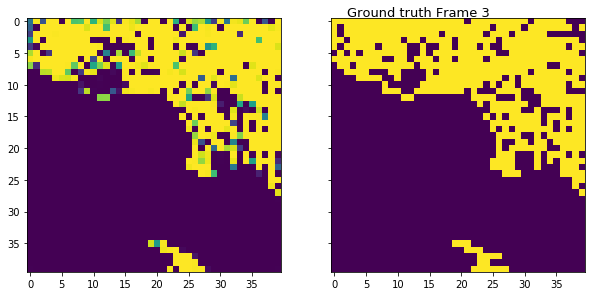

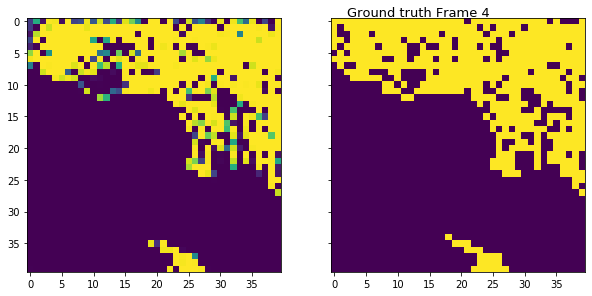

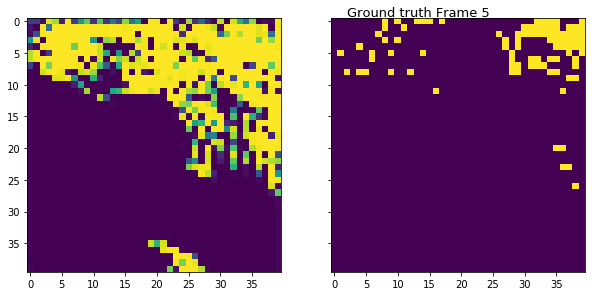

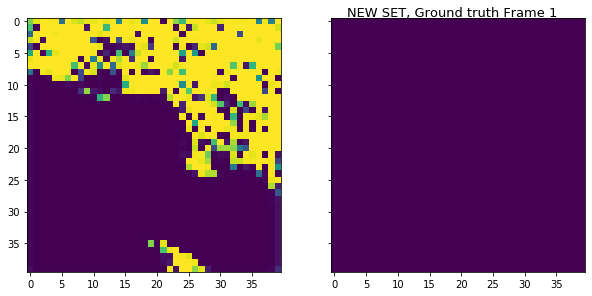

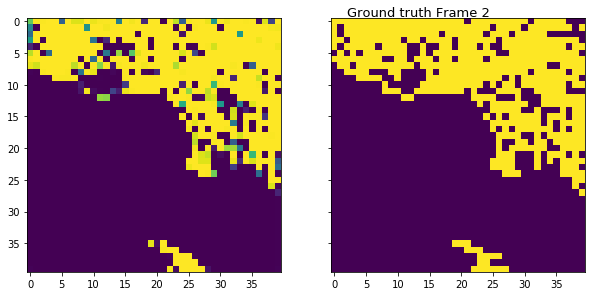

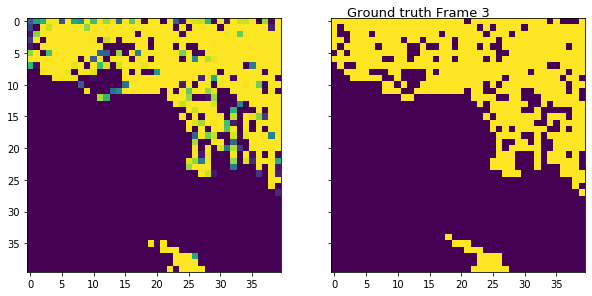

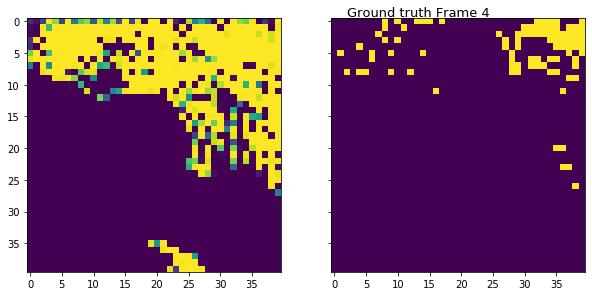

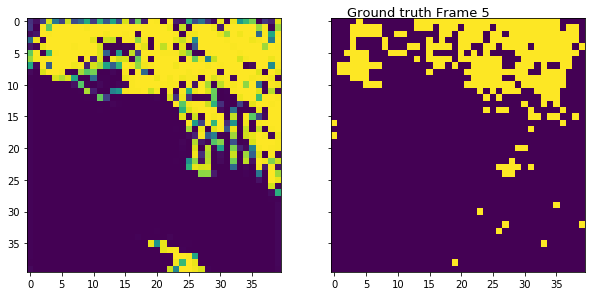

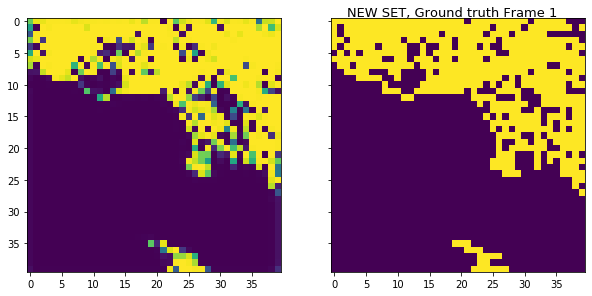

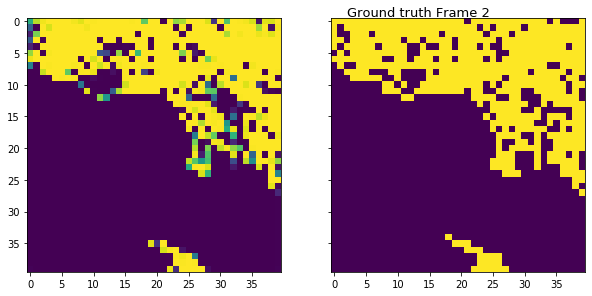

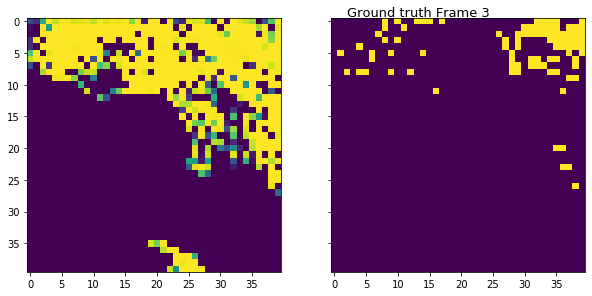

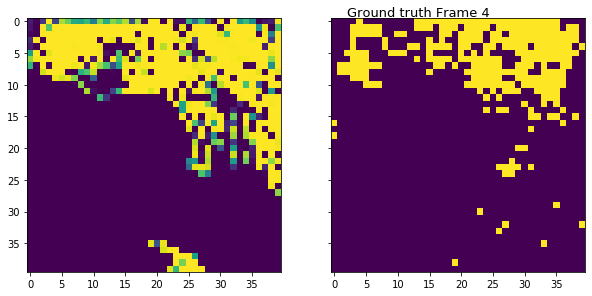

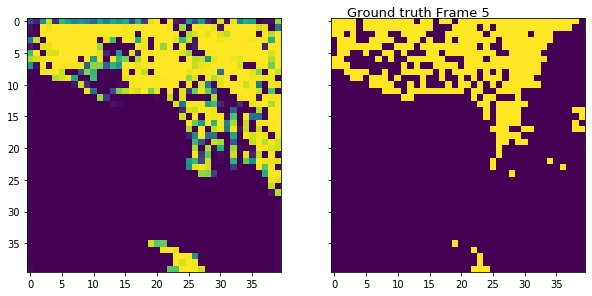

In [105]:
visulization(y_test, Y_hat, 10)

Each frame is 2-3 days apart, this was predicting 10 frames in the future (2 bundles of 5 sets), or around 1 month in the future (April 2020)

In [106]:
Y_hat[Y_hat > 0.5] = 1

In [107]:
Y_hat[Y_hat <= 0.5] = 0

## error analysis

In [108]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage import data, img_as_float
def compare_single_frame(frameA, frameB):
    #saveA = cv2.cvtColor(frameA, cv2.COLOR_BGR2GRAY)
    #saveB = frameB
    #img_grayA = cv2.cvtColor(frameA, cv2.COLOR_BGR2GRAY)
    #img_grayB = cv2.cvtColor(frameB, cv2.COLOR_BGR2GRAY)
    '''
    img_grayA = img_gray.astype('float64')
    floatimgA = img_as_float(img_grayA)
    noiseA = np.ones_like(floatimgA) * 0.2 * (floatimgA.max() - floatimgA.min())
    noiseA[np.random.random(size=noiseA.shape) > 0.5] *= -1
    floatimg_nA = floatimgA + noiseA
    floatimg_cA = floatimgA + abs(noiseA)
    floatimg_cA = floatimg_cA.astype('uint8')
    floatimg_nA = floatimg_nA.astype('uint8')
    (thresh, img_bwA) = cv2.threshold(floatimg_cA, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_grayB = img_grayB.astype('float64')
    floatimgB = img_as_float(img_grayB)
    noiseB = np.ones_like(floatimgB) * 0.2 * (floatimgB.max() - floatimgB.min())
    noiseB[np.random.random(size=noiseB.shape) > 0.5] *= -1
    floatimg_nB = floatimgB + noiseB
    floatimg_cB = floatimgB + abs(noiseB)
    floatimg_cB = floatimg_cB.astype('uint8')
    floatimg_nB = floatimg_nB.astype('uint8')
    (thresh, img_bwB) = cv2.threshold(floatimg_cB, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    '''
    #(thresh, img_bwA) = cv2.threshold(img_grayA, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #(thresh, img_bwB) = cv2.threshold(img_grayB, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    m = mse(frameA,frameB)
    s = ssim(frameA,frameB)
    
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    axs[0].imshow(frameA,cmap="gray")
    axs[0].set_title("Predicted")
    axs[1].imshow(frameB, cmap="gray")
    axs[1].set_title(" MSE: %.2f, SSIM: %.2f"% (m,s))
    plt.show()
    

/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


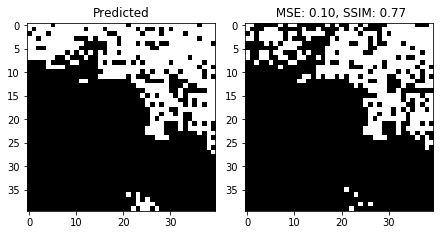

In [109]:
compare_single_frame(Y_hat[7,0,:,:,0],y_test[37,0,:,:,0])

In [110]:
Y_hat[5,0,:,:,:].mean()

0.27375

In [111]:
def compare_single_sample(sampleA, sampleB):
    fig, axs = plt.subplots(5,2,sharey=True, sharex=True, figsize=(20,20))
    fig.tight_layout()
    sample_m = 0
    sample_s = 0
    #saveSA = sampleA
    #saveSB = sampleB
    for frame in range(0,5):
        #saveA = cv2.cvtColor(saveSA[frame], cv2.COLOR_BGR2GRAY)
        #saveB = saveSB[frame]
        frameA = sampleA[frame]
        frameB = sampleB[frame]
        #img_grayA = cv2.cvtColor(sampleA[frame], cv2.COLOR_BGR2GRAY)
        #img_grayB = cv2.cvtColor(sampleB[frame], cv2.COLOR_BGR2GRAY)
        #(threshA, img_bwA) = cv2.threshold(img_grayA, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        #(threshB, img_bwB) = cv2.threshold(img_grayB, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        m = mse(frameA,frameB)
        s = ssim(frameA,frameB)
    
        sample_m = sample_m + m/5.0
        sample_s = sample_s + s/5.0
        axs[frame][0].imshow(frameA,cmap='gray')
        axs[frame][1].imshow(frameB, cmap="gray")
        axs[frame][0].set_title("Predicted Frame")
        axs[frame][1].set_title(" MSE: %.2f, SSIM: %.2f"% (m,s))
        
    fig.suptitle("Sample Difference (5 Frames) \n MSE: %.2f, SSIM: %.2f" % (sample_m,sample_s))
    plt.show()
    

/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


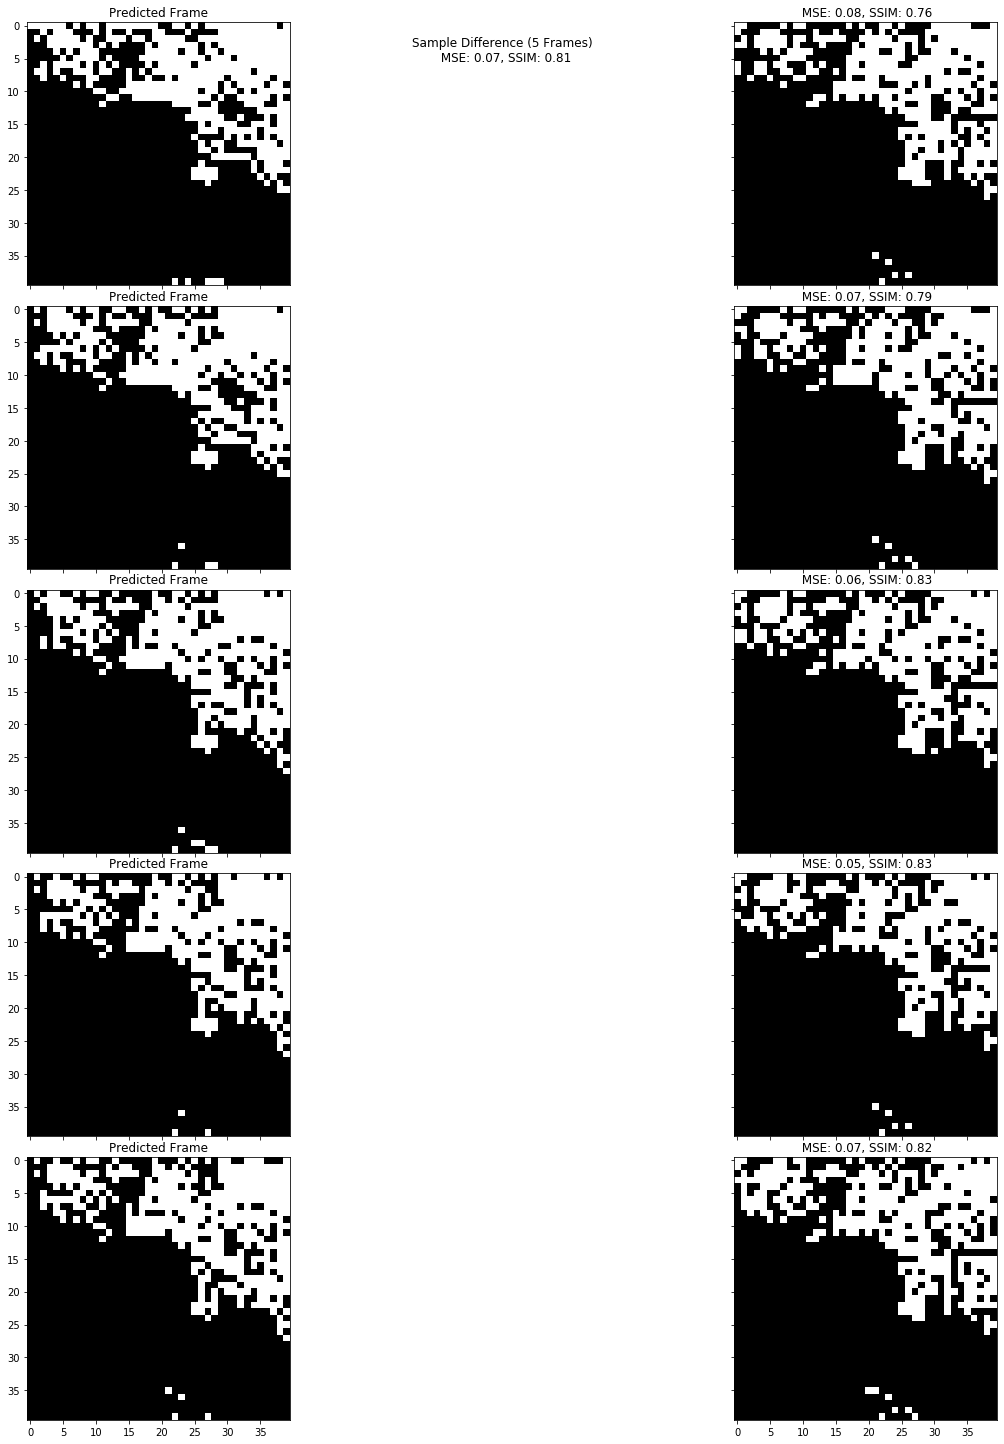

In [117]:
compare_single_sample(Y_hat[37,:,:,:,0],y_test[37,:,:,:,0])

## save as video

In [118]:
def visulization2(y, y_hat, start_index=45, end_index=45):

    '''
    visulize the prpcess of prediction by randomly select n_slots predictions.
    y: the labels of test set: shape like (200, 9, 9, 1)
    y_hat: the predicted labels: shape like (200, 9, 9, 1)
    n_slots: number of frames to be visulized
    '''

   
  
    #print(y.shape)
    counter = start_index
    length = y_hat.shape[0]
    #random_ind = random.sample(range(0, length-1), n_slots)
    image_indexes = [x for x in range(start_index, end_index+1)]
    
    stations = ['0', '1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39']
#     fea = ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pressure', 'temperature', 'humidity']
    fea = ['0', '1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39']
    #y_side = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39].reverse()
    for sample_index in image_indexes:#previous samply_index was ind
        
        for frame_index in range(5):
          fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 10))
          
         # plt.yticks(np.arange(40), stations, fontsize=12)
          #plt.yticks(y_side, stations, fontsize=12)
          #ax1.set_yticklabels(stations,fontsize=13)
          ax1.set_xticklabels(fea)
  #         plt.xticks = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]
         # plt.setp(ax1, xticks = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])#[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]
          #plt.setp(ax1, xticks = x_side[0:40])#[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]
      
          #plt.setp(ax1.get_xticklabels(), rotation=30,ha="right", rotation_mode="anchor")
          #plt.setp(ax2.get_xticklabels(), rotation=30)
  #         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
  #         ax1 = pyplot.subplot(121)
          y_pre = y_hat[sample_index,frame_index,:,:,0] #visulize the last frame
          ax1.imshow(y_pre)
  #         plt.title('Predition', fontsize=15)
          #plt.text(-9, -0.8, 'Prediction' + str(counter), fontsize=13)
  #         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
  #         ax2 = pyplot.subplot(122,sharey=ax1)
          y_truth = y[sample_index,frame_index,:,:,0]#frame index will always be 0 to 10, and sample index will be 0-200, since we have 200 samples intesting test ad prediction set also called yhat
          
          ax2.imshow(y_truth)

  #         plt.title('Ground truth', fontsize=15)
          plt.text(2, -0.8, 'Ground truth' + str(counter), fontsize=13)

        
          #os.join.path()
          #file_nmae = 'prediction_truth_sample' +  str(sample_index) + 'frame' + str(frame_index)+ '.png'
          file_name = '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample' +  str(sample_index) + str(frame_index)+ '.png'
          #file_name = 'prediction' + str(counter) + '.png'
          #print(file_name)
          plt.savefig(file_name, dpi=300, bbox_inches ='tight')   
          counter+=1 
          #plt.savefig('predict-map.png', dpi=300, bbox_inches ='tight')

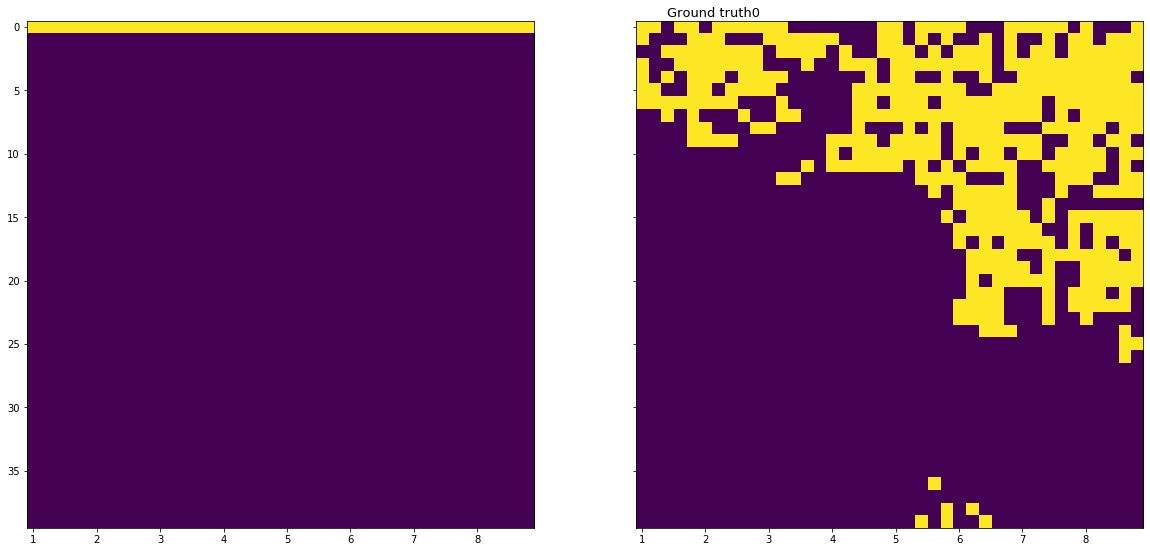

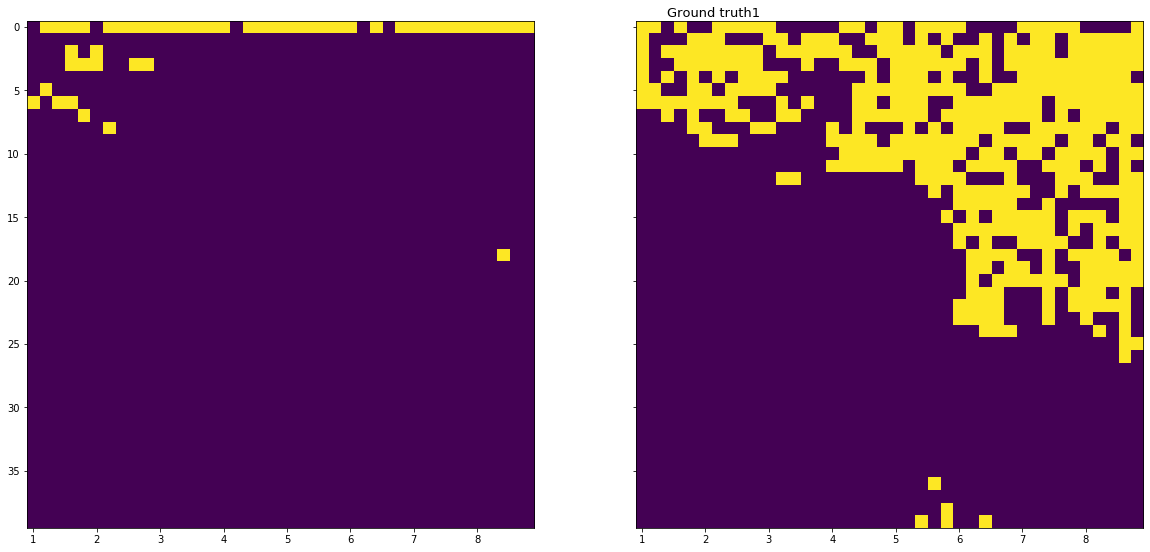

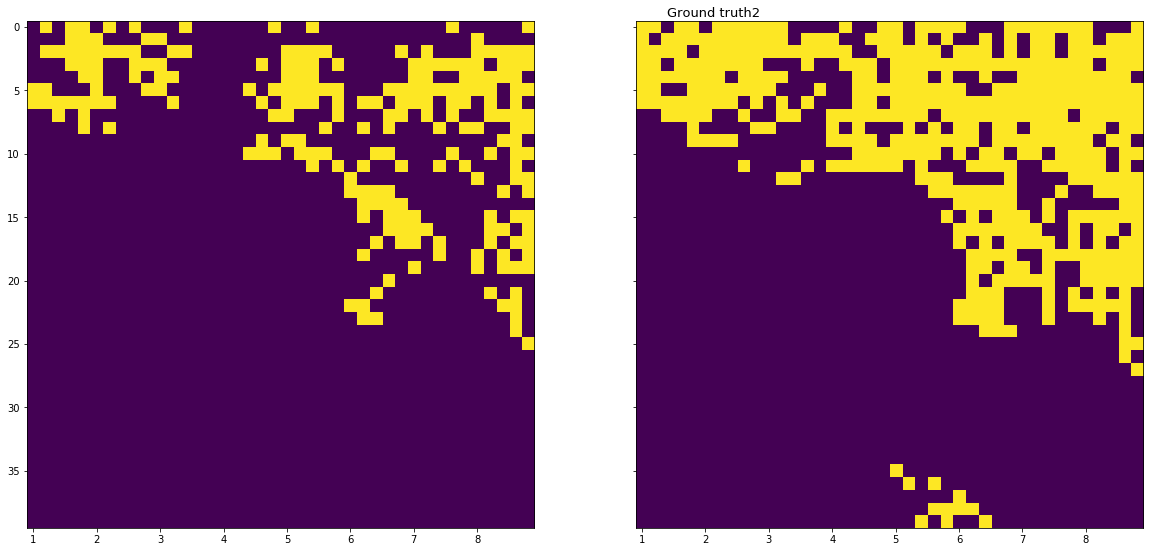

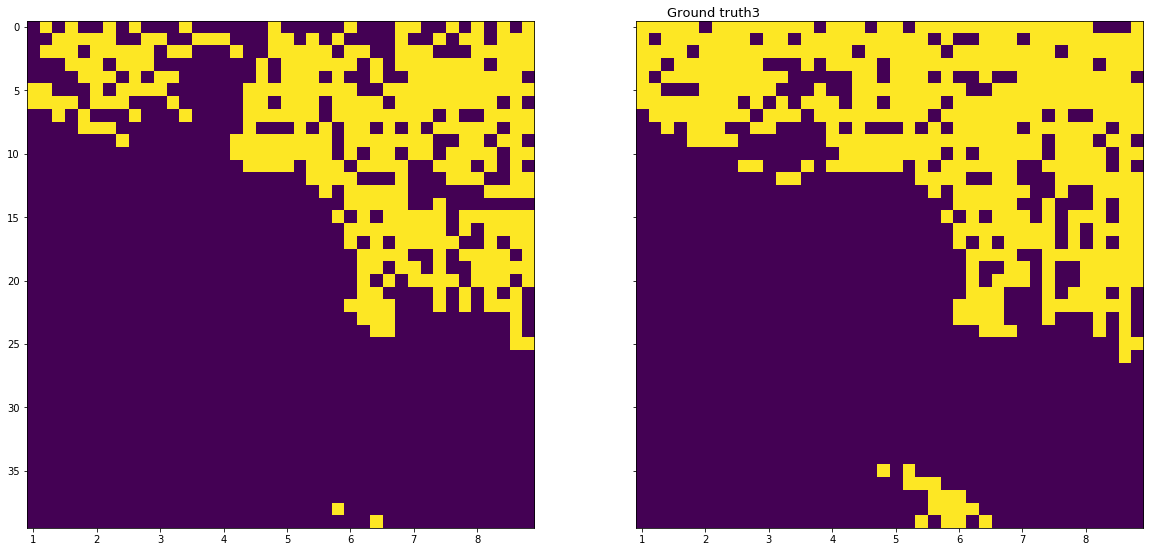

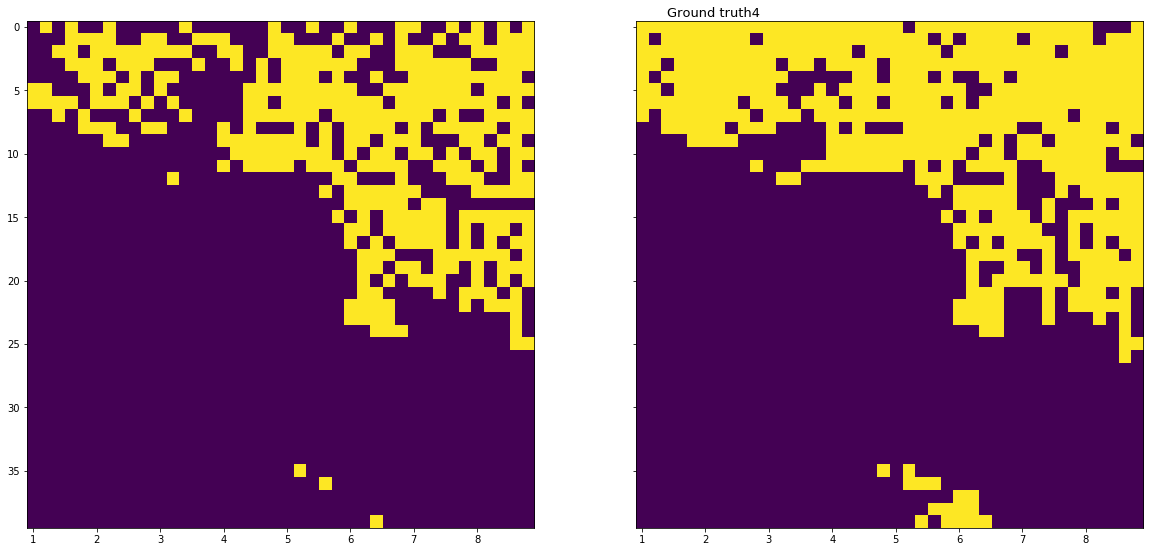

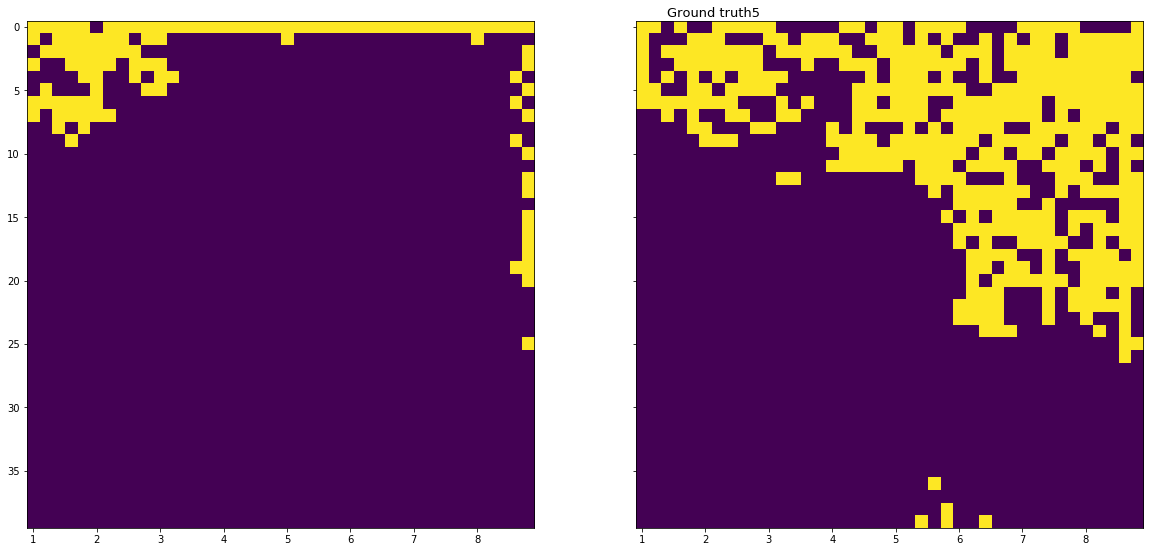

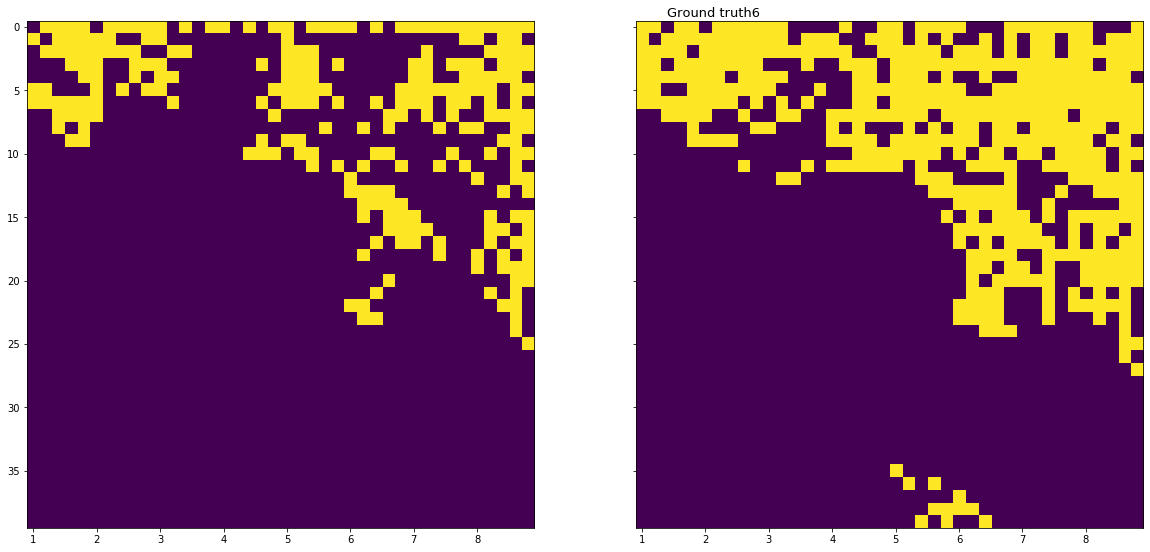

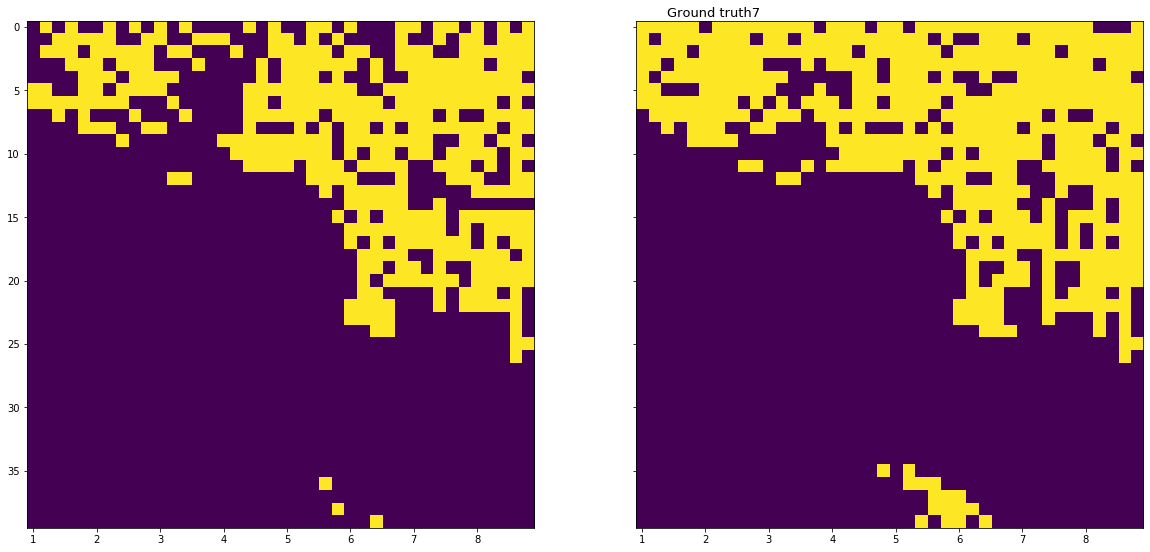

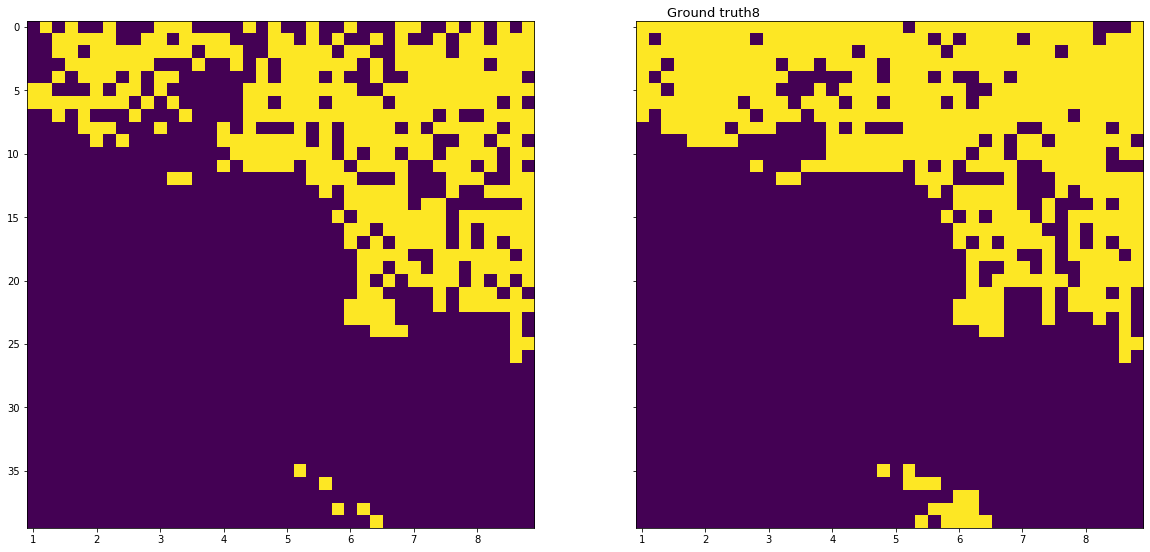

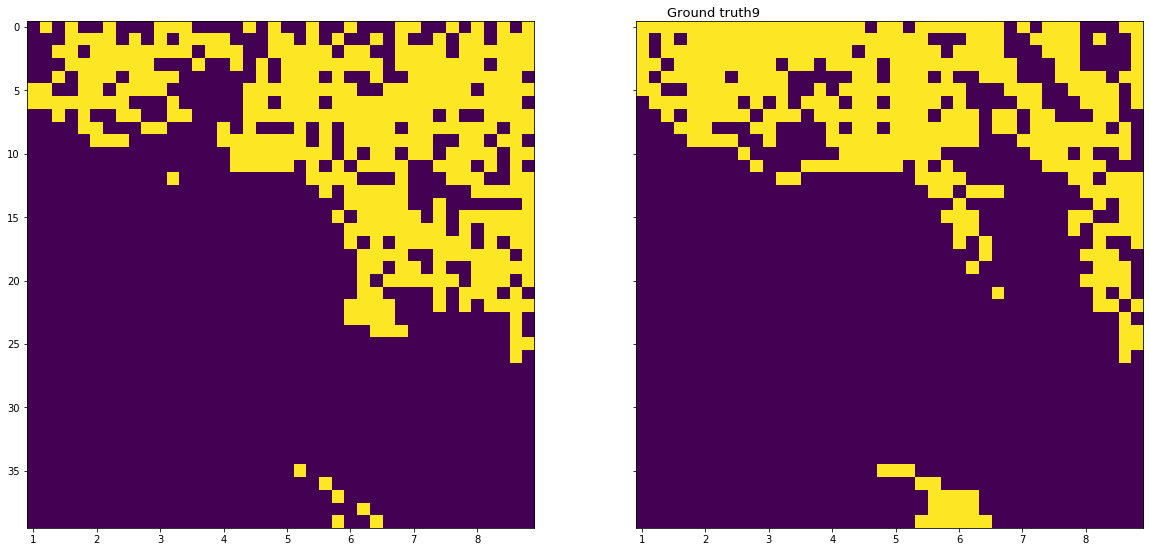

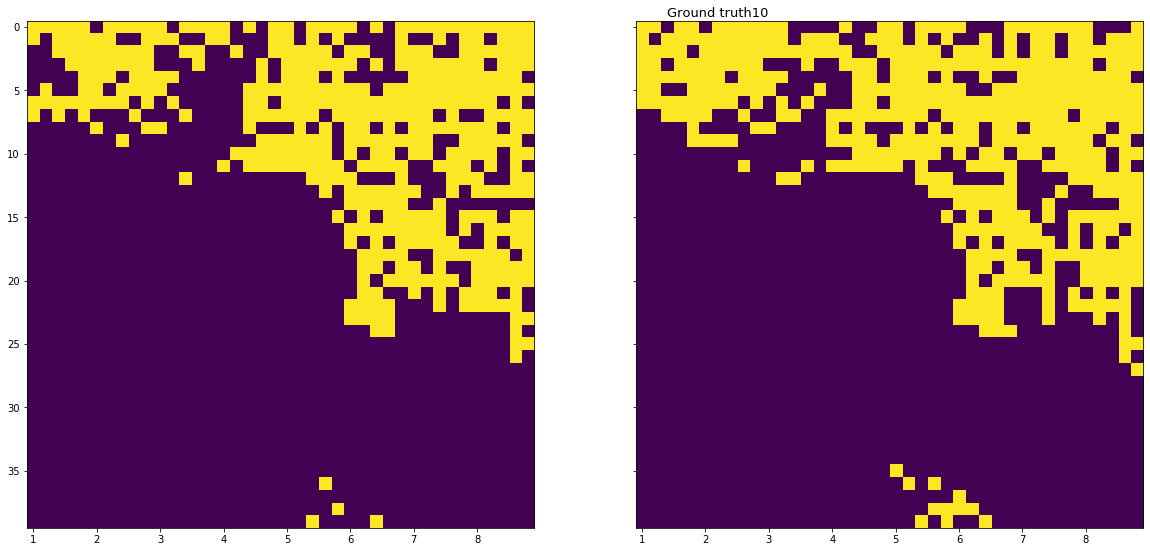

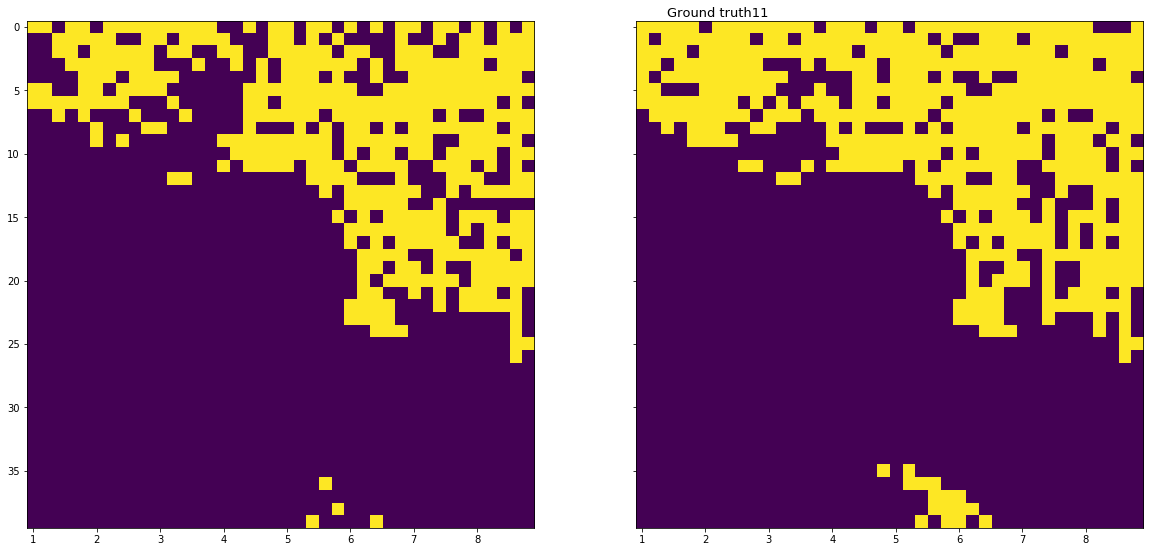

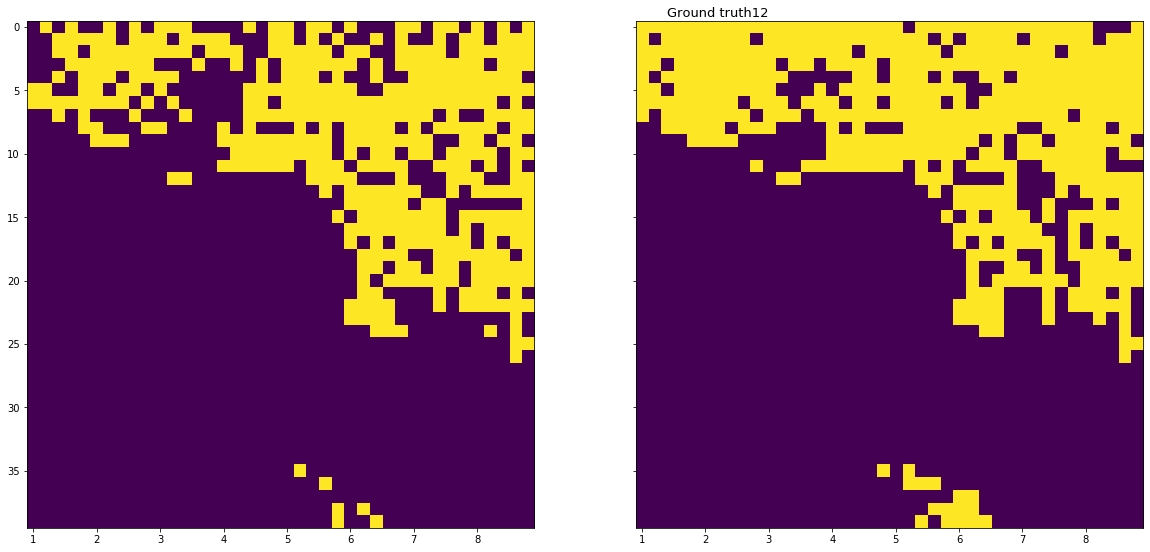

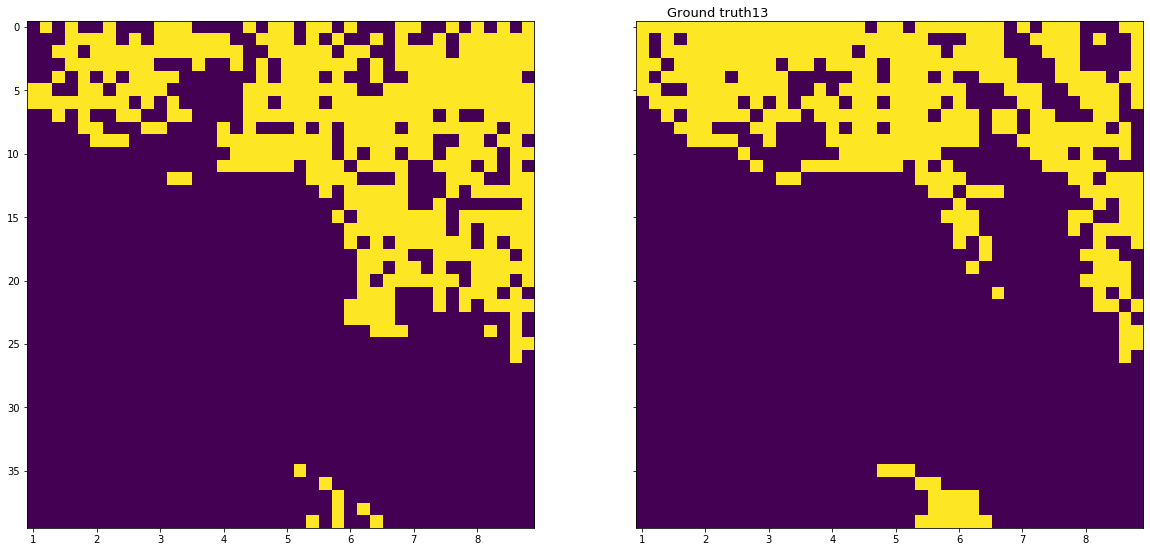

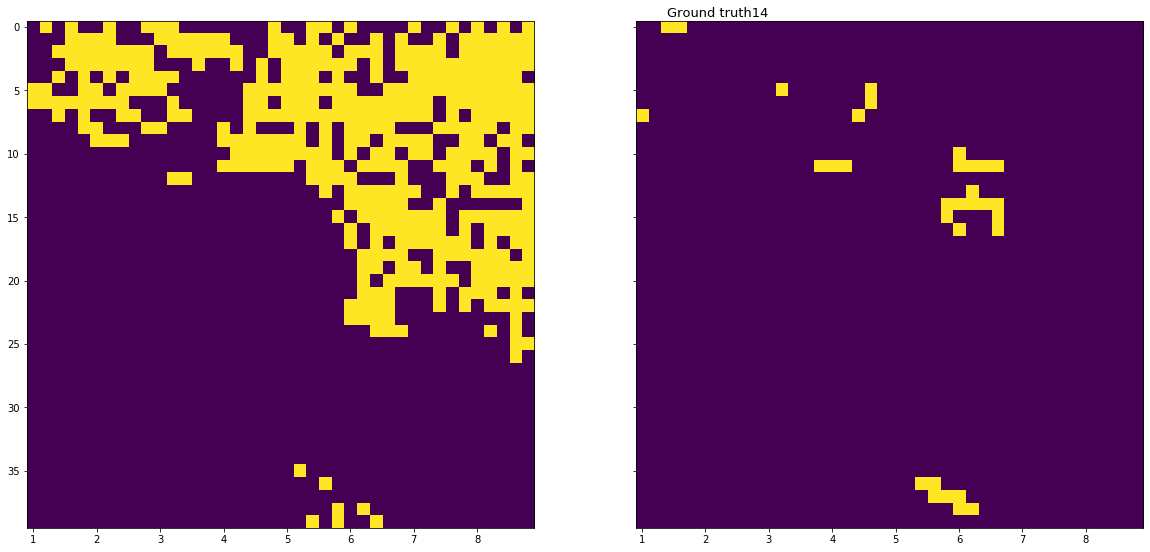

In [120]:
visulization2(y_test, Y_hat, start_index = 0, end_index = 2)

In [82]:
image_names_to_read = []
for sample_index in range(54):
  for frame_index in range(5):
    file_name = 'prediction_truth_sample' +  str(sample_index) + str(frame_index)+ '.png'
    image_names_to_read.append(file_name)


In [83]:
image_names_to_read[0:10]

['prediction_truth_sample00.png',
 'prediction_truth_sample01.png',
 'prediction_truth_sample02.png',
 'prediction_truth_sample03.png',
 'prediction_truth_sample04.png',
 'prediction_truth_sample10.png',
 'prediction_truth_sample11.png',
 'prediction_truth_sample12.png',
 'prediction_truth_sample13.png',
 'prediction_truth_sample14.png']

In [84]:
full_image_path = [os.path.join('/Users/Pannu/Desktop/Video Frames/' , x) for x in image_names_to_read]


In [85]:
full_image_path[0:10]

['/Users/Pannu/Desktop/Video Frames/prediction_truth_sample00.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample01.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample02.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample03.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample04.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample10.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample11.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample12.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample13.png',
 '/Users/Pannu/Desktop/Video Frames/prediction_truth_sample14.png']

In [86]:
import cv2
import numpy as np
import glob
 

def create_video(all_images_path):

  img_array = []
  #for filename in glob.glob('C:/New folder/Images/*.jpg'):
  for filename in all_images_path:
      print(filename)
      img = cv2.imread(filename)
      #print(img)
      #print(type(img))
      height, width, layers = img.shape
      size = (width,height)
      img_array.append(img)
  
  
  #out = cv2.VideoWriter('Prediction_Vs_Truth2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
  out = cv2.VideoWriter('StaggeredPredictionVsTruth.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
  
  for i in range(len(img_array)):
      out.write(img_array[i])
  out.release()

In [87]:
create_video(full_image_path)

/Users/Pannu/Desktop/Video Frames/prediction_truth_sample00.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample01.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample02.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample03.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample04.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample10.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample11.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample12.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample13.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample14.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample20.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample21.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample22.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample23.png
/Users/Pannu/Desktop/Video Frames/prediction_truth_sample24.png
/Users/Pannu/Desktop/Video Frames/predic